#Part 4

REF:

*   https://keras.io/examples/generative/conditional_gan/

*   https://www.coursera.org/lecture/build-basic-generative-adversarial-networks-gans/conditional-generation-inputs-2OPrG

*   https://www.youtube.com/watch?v=W5NPlZzebO0  



In [1]:
'''importing necessary libraries'''
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import logging
logging.getLogger().setLevel(logging.ERROR)

In [2]:
'''importing mnist dataset'''
(xtrain, ytrain), (xtest, ytest) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
'''
pre processing data as required
#     flattening the image and then using matematical scaling to get the data in shape of -1 to 1
#     converting the labels to one hot vector of the labels'''
xtrain_flattened = xtrain.reshape((xtrain.shape[0], -1))
xtrain_flattened_scaled = (xtrain_flattened / 127.5) - 1.0
xtest_flattened = xtest.reshape((xtest.shape[0], -1))
xtest_flattened_scaled = (xtest_flattened / 127.5) - 1.0
ytrain_one_hot = tf.keras.utils.to_categorical(ytrain, 10)
ytest_one_hot = tf.keras.utils.to_categorical(ytest, 10)

In [ ]:
'''viewing the shape of the data'''
print(f"Shape of xtrain_flattened: {xtrain_flattened.shape}")
print(f"Shape of ytrain_one_hot: {ytrain_one_hot.shape}")
print(f"Shape of xtest_flattened: {xtest_flattened.shape}")
print(f"Shape of ytest_one_hot: {ytest_one_hot.shape}")

Shape of xtrain_flattened: (60000, 784)
Shape of ytrain_one_hot: (60000, 10)
Shape of xtest_flattened: (10000, 784)
Shape of ytest_one_hot: (10000, 10)


In [ ]:
'''verifying is the data scalled in the range of -1 to 1 or not'''
print('Training')
print('Scaled Min:', np.min(xtrain_flattened_scaled))
print('Scaled Max:', np.max(xtrain_flattened_scaled))
print('Original Min:', np.min(xtrain_flattened))
print('Original Max:', np.max(xtrain_flattened))

Training
Scaled Min: -1.0
Scaled Max: 1.0
Original Min: 0
Original Max: 255


In [ ]:
'''verifying is the data scalled in the range of -1 to 1 or not'''
print('Testing')
print('Scaled Min:', np.min(xtest_flattened_scaled))
print('Scaled Max:', np.max(xtest_flattened_scaled))
print('Original Min:', np.min(xtest_flattened))
print('Original Max:', np.max(xtest_flattened))

Testing
Scaled Min: -1.0
Scaled Max: 1.0
Original Min: 0
Original Max: 255


In [ ]:
''' Creating a model for discriminator '''
d = 100

input_noise_generator = tf.keras.layers.Input(shape=(d,))
input_data_generator = tf.keras.layers.Input(shape=(10,))

# Generator model
generator_model = tf.keras.models.Sequential()
generator_model.add(tf.keras.layers.Dense(units=200, activation='relu',kernel_initializer='HeNormal'))
generator_model.add(tf.keras.layers.Dense(units=400, activation='relu',kernel_initializer='HeNormal'))
generator_model.add(tf.keras.layers.Dense(units=784, activation='tanh'))

# Combine noise and data_input
combined_input = tf.keras.layers.Concatenate(axis=1)([input_noise_generator, input_data_generator])

# Apply the generator to the combined input
generator_output = generator_model(combined_input)

# Create the final model
generator_gan = tf.keras.models.Model([input_noise_generator, input_data_generator], generator_output, name='generator')

# Display the summary of the model
generator_gan.summary()


Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 input_14 (InputLayer)       [(None, 10)]                 0         []                            
                                                                                                  
 concatenate_6 (Concatenate  (None, 110)                  0         ['input_13[0][0]',            
 )                                                                   'input_14[0][0]']            
                                                                                                  
 sequential_6 (Sequential)   (None, 784)                  416984    ['concatenate_6[0][0]'

In [ ]:
''' Creating a model for discriminator '''
img_shape = 784
classes = 10

input_image_data_discriminator = tf.keras.layers.Input(shape=(img_shape,))
input_label_data_discriminator = tf.keras.layers.Input(shape=(classes,))

# Discriminator model
discriminator = tf.keras.models.Sequential()
discriminator.add(tf.keras.layers.Dense(400,kernel_initializer='HeNormal',activation='relu'))
discriminator.add(tf.keras.layers.Dense(200,kernel_initializer='HeNormal',activation='relu'))
discriminator.add(tf.keras.layers.Dense(100,kernel_initializer='HeNormal',activation='relu'))
discriminator.add(tf.keras.layers.Dense(units=1, activation='sigmoid',kernel_initializer='GlorotNormal'))
combined_input = tf.keras.layers.Concatenate(axis=1)([input_image_data_discriminator, input_label_data_discriminator])
discriminator_gan = tf.keras.models.Model([input_image_data_discriminator, input_label_data_discriminator], discriminator(combined_input), name='discriminator')
discriminator_gan.summary()


Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 784)]                0         []                            
                                                                                                  
 input_16 (InputLayer)       [(None, 10)]                 0         []                            
                                                                                                  
 concatenate_7 (Concatenate  (None, 794)                  0         ['input_15[0][0]',            
 )                                                                   'input_16[0][0]']            
                                                                                                  
 sequential_7 (Sequential)   (None, 1)                    418401    ['concatenate_7[0]

In [22]:
discriminator_gan.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(0.001,0.5), metrics = ['binary_accuracy'])
discriminator_gan.trainable = False

In [23]:
gan_generated_img = generator_gan([input_noise_generator,input_data_generator])
output_from_gan = discriminator_gan([gan_generated_img, input_data_generator])

In [24]:
cgan = tf.keras.models.Model([input_noise_generator, input_data_generator], output_from_gan)

In [25]:

cgan.compile(loss= 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(0.001,0.5))

In [26]:
def generate_random_normal_data_with_Labels(a,b):
  return  np.random.normal(0,1,size = (a, b)) , tf.keras.utils.to_categorical(np.random.choice(10, a, replace=True) , num_classes=10)

In [17]:
''' Making  a function that returns the random normal dataset with labels along with that for the fake data '''
def generate_random_normal_data_with_Labels(a,b):
  return  np.random.normal(0,1,size = (a, b)) , tf.keras.utils.to_categorical(np.random.choice(10, a, replace=True) , num_classes=10)
epochs = 100
batch_size = 500
epoch_info_list = []
for epoch in range(epochs):
  for i in range(0,len(xtrain_flattened_scaled),batch_size):
      ''' Making the discriminator trainable'''
      discriminator_gan.trainable = True
      '''training Discriminator on real data'''
      real_loss,real_accuracy = discriminator_gan.train_on_batch([ xtrain_flattened_scaled[i:i+batch_size,:], ytrain_one_hot[i:i+batch_size,:]], np.ones(shape= (batch_size, 1)))
      '''Generating fake data'''
      random_normal_data,generate_random_labels1 = generate_random_normal_data_with_Labels(batch_size, d)
      '''training Discriminator on fake data where u use images that are predicted from generator and the final label is 0 '''
      fake_loss,fake_accuracy = discriminator_gan.train_on_batch([generator_gan.predict([xtrain_flattened_scaled[i:i+batch_size,:].reshape([-1,28,28])[:,9:19,9:19].reshape(-1,100),generate_random_labels1],verbose = None), generate_random_labels1],  np.zeros(shape = (batch_size,1)))
      ''' updatind the final loss '''
      discrimnator_gan_loss= 0.5 * np.add(real_loss,fake_loss)
      ''' Making the discriminator not trainable'''
      discriminator_gan.trainable = False
      '''Generating fake data'''
      random_normal_data,generate_random_labels = generate_random_normal_data_with_Labels(batch_size, d)
      '''training the whole cgan model indirectly training the generator as it is being directly with the whole cgan model '''
      cgan_loss = cgan.train_on_batch([generator_gan.predict([xtrain_flattened_scaled[i:i+batch_size,:].reshape([-1,28,28])[:,9:19,9:19].reshape(-1,100),generate_random_labels1],verbose = None).reshape([-1,28,28])[:,9:19,9:19].reshape(-1,100),generate_random_labels], np.ones(shape= (batch_size, 1)))  + ( 10 * np.mean(np.square(generator_gan.predict([xtrain_flattened_scaled[i:i+batch_size,:].reshape([-1,28,28])[:,9:19,9:19].reshape(-1,100),generate_random_labels1],verbose = None).reshape([-1,28,28])[:,9:19,9:19].reshape(-1,100) - random_normal_data)))
  print(f"Epoch: {epoch + 1}")
  # Create a dictionary with the epoch & loss info
  epoch_info = {'epoch': epoch+1,'discriminator_loss': discrimnator_gan_loss,'real_accuracy': real_accuracy,'fake_accuracy': fake_accuracy,'generator_loss': cgan_loss}
  print(epoch_info)
  epoch_info_list.append(epoch_info)


Epoch: 1
{'epoch': 1, 'discriminator_loss': 0.26293815672397614, 'real_accuracy': 0.9559999704360962, 'fake_accuracy': 0.8799999952316284, 'generator_loss': 18.130323688526886}
Epoch: 2
{'epoch': 2, 'discriminator_loss': 0.4433640241622925, 'real_accuracy': 0.7919999957084656, 'fake_accuracy': 0.7699999809265137, 'generator_loss': 17.810442930351115}
Epoch: 3
{'epoch': 3, 'discriminator_loss': 0.43983733654022217, 'real_accuracy': 0.8180000185966492, 'fake_accuracy': 0.7379999756813049, 'generator_loss': 17.163254476648248}
Epoch: 4
{'epoch': 4, 'discriminator_loss': 0.7001221477985382, 'real_accuracy': 0.5600000023841858, 'fake_accuracy': 0.6600000262260437, 'generator_loss': 17.297190513259565}
Epoch: 5
{'epoch': 5, 'discriminator_loss': 0.40001147985458374, 'real_accuracy': 0.8320000171661377, 'fake_accuracy': 0.8240000009536743, 'generator_loss': 17.2257173054278}
Epoch: 6
{'epoch': 6, 'discriminator_loss': 0.47496916353702545, 'real_accuracy': 0.7699999809265137, 'fake_accuracy': 

In [18]:
generator_gan.save('generator.h5')
discriminator_gan.save('discriminator.h5')
cgan.save('cgan.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
'''
resusing the model and generating the indices and made it using the above code in q1,q2,q3
'''
def plot_images(img_array):
    fig, axes = plt.subplots(10, 10, figsize=(10, 10))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    axes = axes.flatten()
    for i in range(100):
        axes[i].imshow(img_array[i].reshape(28, 28),cmap = 'Paired')
        axes[i].axis('off')
    plt.show()
x = []
labels = [0,1,2,3,4,5,6,7,8,9]
for i in range(0, 10):
    indices_with_label = np.where(ytest == labels[i])[0]
    shuffled_indices = np.random.permutation(indices_with_label)
    selected_indices = shuffled_indices[:10]
    x += list(selected_indices)

img_ = xtest[x]
img_flattened = img_.reshape([-1,28,28])
img_flattened_scaled = (img_flattened / 127.5) - 1.0
generate_sample_test_center_img = np.vstack([img_flattened_scaled[:, 9:19, 9:19].reshape(-1, 100)])
generate_sample_test_labels = tf.one_hot(ytest[np.stack(x)],depth = 10)


4/4 [==============================] - 0s 3ms/step


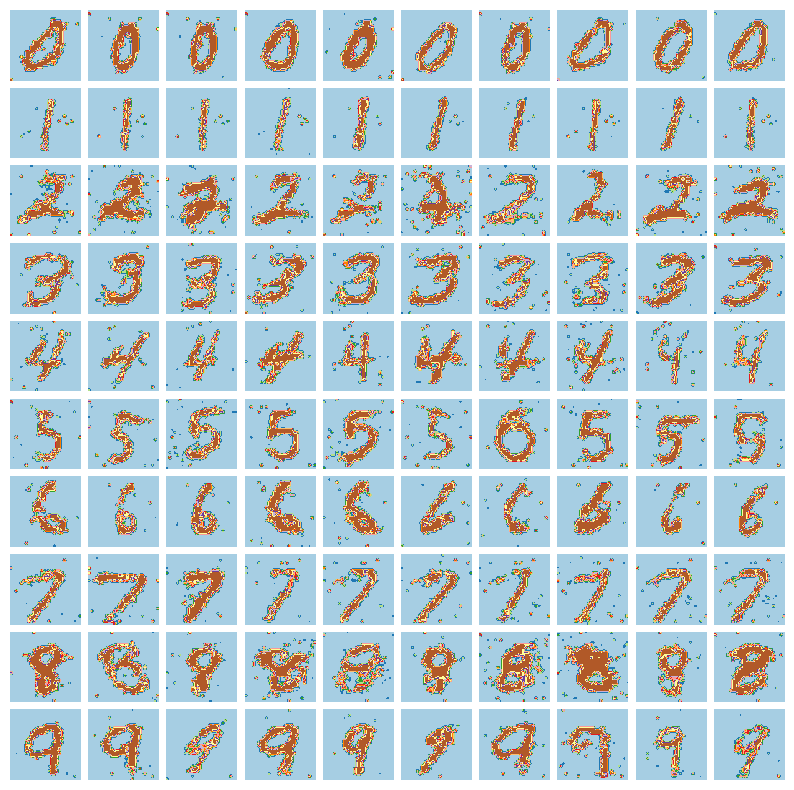

In [20]:
plot_images((generator_gan.predict([generate_sample_test_center_img,generate_sample_test_labels])+1)*0.5)

In [27]:
''' Making  a function that returns the random normal dataset with labels along with that for the fake data '''
def generate_random_normal_data_with_Labels(a,b):
  return  np.random.normal(0,1,size = (a, b)) , tf.keras.utils.to_categorical(np.random.choice(10, a, replace=True) , num_classes=10)
epochs = 100
batch_size = 500
epoch_info_list = []
for epoch in range(epochs):
  for i in range(0,len(xtrain_flattened_scaled),batch_size):
      ''' Making the discriminator trainable'''
      discriminator_gan.trainable = True
      '''training Discriminator on real data'''
      real_loss,real_accuracy = discriminator_gan.train_on_batch([ xtrain_flattened_scaled[i:i+batch_size,:], ytrain_one_hot[i:i+batch_size,:]], np.ones(shape= (batch_size, 1)))
      '''Generating fake data'''
      random_normal_data,generate_random_labels1 = generate_random_normal_data_with_Labels(batch_size, d)
      '''training Discriminator on fake data where u use images that are predicted from generator and the final label is 0 '''
      fake_loss,fake_accuracy = discriminator_gan.train_on_batch([generator_gan.predict([xtrain_flattened_scaled[i:i+batch_size,:].reshape([-1,28,28])[:,9:19,9:19].reshape(-1,100),generate_random_labels1],verbose = None), generate_random_labels1],  np.zeros(shape = (batch_size,1)))
      ''' updatind the final loss '''
      discrimnator_gan_loss= 0.5 * np.add(real_loss,fake_loss)
      ''' Making the discriminator not trainable'''
      discriminator_gan.trainable = False
      '''Generating fake data'''
      random_normal_data,generate_random_labels = generate_random_normal_data_with_Labels(batch_size, d)
      '''training the whole cgan model indirectly training the generator as it is being directly with the whole cgan model '''
      cgan_loss = cgan.train_on_batch([generator_gan.predict([xtrain_flattened_scaled[i:i+batch_size,:].reshape([-1,28,28])[:,9:19,9:19].reshape(-1,100),generate_random_labels1],verbose = None).reshape([-1,28,28])[:,9:19,9:19].reshape(-1,100),generate_random_labels], np.ones(shape= (batch_size, 1)))  + ( 0.1 * np.mean(np.square(generator_gan.predict([xtrain_flattened_scaled[i:i+batch_size,:].reshape([-1,28,28])[:,9:19,9:19].reshape(-1,100),generate_random_labels1],verbose = None).reshape([-1,28,28])[:,9:19,9:19].reshape(-1,100) - random_normal_data)))
  print(f"Epoch: {epoch + 1}")
  # Create a dictionary with the epoch & loss info
  epoch_info = {'epoch': epoch+1,'discriminator_loss': discrimnator_gan_loss,'real_accuracy': real_accuracy,'fake_accuracy': fake_accuracy,'generator_loss': cgan_loss}
  print(epoch_info)
  epoch_info_list.append(epoch_info)


Epoch: 1
{'epoch': 1, 'discriminator_loss': 0.6786976456642151, 'real_accuracy': 0.593999981880188, 'fake_accuracy': 0.5460000038146973, 'generator_loss': 0.9520870239136366}
Epoch: 2
{'epoch': 2, 'discriminator_loss': 0.6703544855117798, 'real_accuracy': 0.6000000238418579, 'fake_accuracy': 0.5559999942779541, 'generator_loss': 0.9576693465400723}
Epoch: 3
{'epoch': 3, 'discriminator_loss': 0.6786251366138458, 'real_accuracy': 0.5419999957084656, 'fake_accuracy': 0.5139999985694885, 'generator_loss': 0.9487983009096315}
Epoch: 4
{'epoch': 4, 'discriminator_loss': 0.6753615140914917, 'real_accuracy': 0.5440000295639038, 'fake_accuracy': 0.5839999914169312, 'generator_loss': 0.9651124642339508}
Epoch: 5
{'epoch': 5, 'discriminator_loss': 0.6687115728855133, 'real_accuracy': 0.5920000076293945, 'fake_accuracy': 0.5619999766349792, 'generator_loss': 0.9602467892051717}
Epoch: 6
{'epoch': 6, 'discriminator_loss': 0.6762187480926514, 'real_accuracy': 0.6179999709129333, 'fake_accuracy': 0.4

In [28]:
'''
resusing the model and generating the indices and made it using the above code in q1,q2,q3
'''
x = []
labels = [0,1,2,3,4,5,6,7,8,9]
for i in range(0, 10):
    indices_with_label = np.where(ytest == labels[i])[0]
    shuffled_indices = np.random.permutation(indices_with_label)
    selected_indices = shuffled_indices[:10]
    x += list(selected_indices)

img_ = xtest[x]
img_flattened = img_.reshape([-1,28,28])
img_flattened_scaled = (img_flattened / 127.5) - 1.0
generate_sample_test_center_img = np.vstack([img_flattened_scaled[:, 9:19, 9:19].reshape(-1, 100)])
generate_sample_test_labels = tf.one_hot(ytest[np.stack(x)],depth = 10)

4/4 [==============================] - 0s 2ms/step


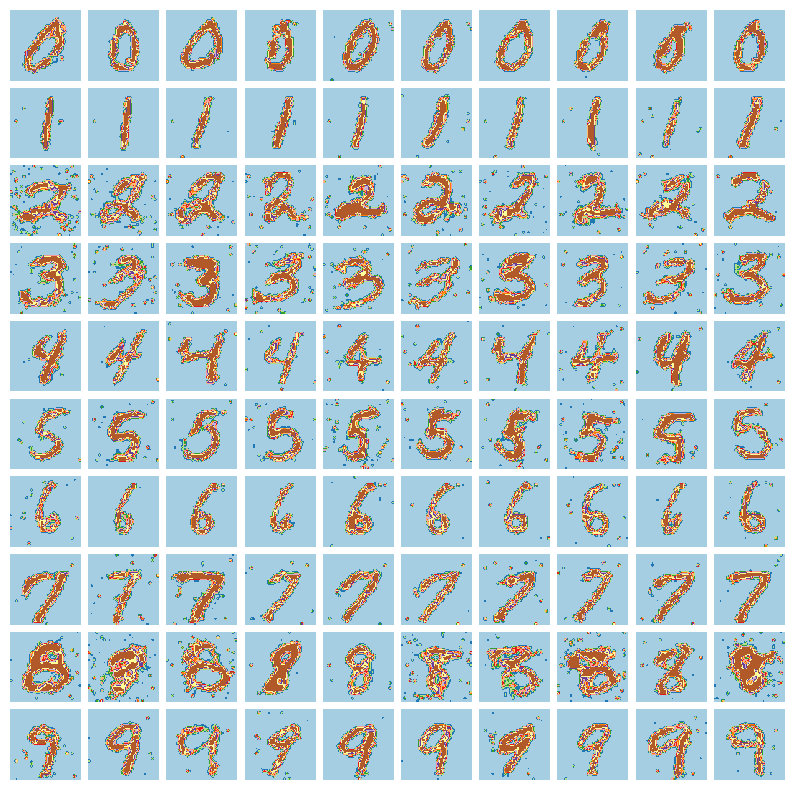

In [29]:
'''
use the code in q1,q2,q3 to plot the images and then normalizing it 
'''
def plot_images(img_array):
    fig, axes = plt.subplots(10, 10, figsize=(10, 10))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    axes = axes.flatten()
    for i in range(100):
        axes[i].imshow(img_array[i].reshape(28, 28),cmap = 'Paired')
        axes[i].axis('off')
    plt.show()
plot_images((generator_gan.predict([generate_sample_test_center_img,generate_sample_test_labels])+1)*0.5)